## Welly and LAS files

Some preliminaries...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import welly
welly.__version__

'0.1.0'

In [3]:
import os
env = %env

## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [4]:
from welly import Well

In [5]:
w = Well.from_las('P-129_out.LAS')

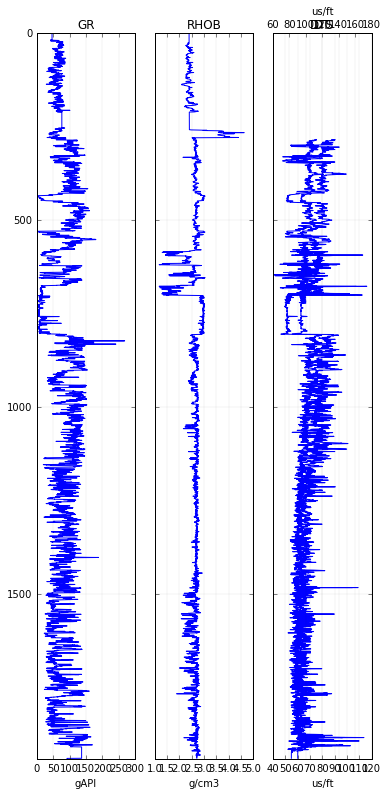

In [6]:
tracks = ['GR', 'RHOB', ['DT', 'DTS']]
w.plot(tracks=tracks)

In [1]:
from striplog import Legend, Striplog
legend = Legend.builtin('NSDOE')
strip = Striplog.from_image('P-129_280_1935.png', 280, 1935, legend=legend)
strip.plot()

In [7]:
w.data['strip'] = strip

## Save LAS file

In [8]:
w.to_las('out.las', keys=['strip', 'GR'])

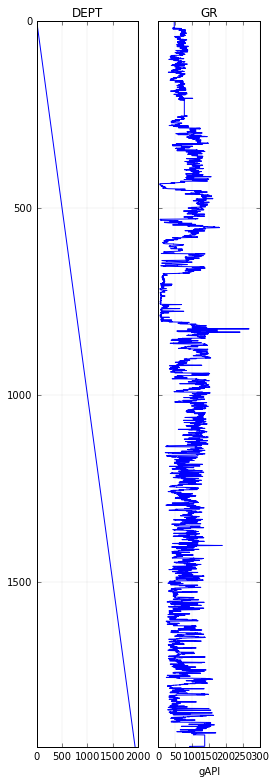

In [9]:
z = Well.from_las('out.las')
z.plot()

## Header

Maybe should be called 'meta' as it's not really a header... 

In [25]:
w.header

{'field': 'Windsor Block', 'license': 'P-129', 'company': 'Elmworth Energy Corporation', 'uwi': "Long = 63* 45'24.460  W", 'name': 'Kennetcook #2'}

In [26]:
w.header.name

'Kennetcook #2'

In [27]:
w.uwi  # Fails because not present in this file. See one way to add it in a minute.

"Long = 63* 45'24.460  W"

## Location and CRS

In [28]:
w.location

Location({'crs': CRS({}), 'province': 'Nova Scotia', 'country': 'CA', 'gl': 90.3, 'section': '45.20 Deg N', 'td': 1935.0, 'position': None, 'tdl': 1935.0, 'kb': 94.8, 'deviation': None, 'location': 'Lat = 45* 12\' 34.237" N', 'range': 'PD 176', 'tdd': 1935.0, 'township': '63.75 Deg W'})

In [29]:
w.location.crs

CRS({})

In [30]:
from welly import CRS
w.location.crs = CRS.from_epsg(2038)

In [31]:
w.location

Location({'crs': CRS({'no_defs': True, 'init': 'epsg:2038'}), 'province': 'Nova Scotia', 'country': 'CA', 'gl': 90.3, 'section': '45.20 Deg N', 'td': 1935.0, 'position': None, 'tdl': 1935.0, 'kb': 94.8, 'deviation': None, 'location': 'Lat = 45* 12\' 34.237" N', 'range': 'PD 176', 'tdd': 1935.0, 'township': '63.75 Deg W'})

## Coping with messy LAS

Some file headers are a disgrace:

    # LAS format log file from PETREL
    # Project units are specified as depth units
    #==================================================================
    ~Version information
    VERS.   2.0:
    WRAP.   YES:
    #==================================================================
    ~WELL INFORMATION
    #MNEM.UNIT      DATA             DESCRIPTION
    #---- ------ --------------   -----------------------------
    STRT .M      1.0668          :START DEPTH     
    STOP .M      1939.13760      :STOP DEPTH     
    STEP .M       0.15240        :STEP        
    NULL .          -999.25      :NULL VALUE
    COMP .        Elmworth Energy Corporation              :COMPANY
    WELL .        Kennetcook #2                            :WELL
    FLD  .        Windsor Block                            :FIELD
    LOC  .        Lat = 45* 12' 34.237" N                  :LOCATION
    PROV .        Nova Scotia                              :PROVINCE
      UWI.        Long = 63* 45'24.460  W                  :UNIQUE WELL ID
    LIC  .        P-129                                    :LICENSE NUMBER
    CTRY .        CA                                       :COUNTRY (WWW code)
     DATE.        10-Oct-2007                              :LOG DATE {DD-MMM-YYYY}
    SRVC .        Schlumberger                             :SERVICE COMPANY
    LATI .DEG                                              :LATITUDE
    LONG .DEG                                              :LONGITUDE
    GDAT .                                                 :GeoDetic Datum
    SECT .        45.20 Deg N                              :Section
    RANG .        PD 176                                   :Range
    TOWN .        63.75 Deg W                              :Township

In [36]:
import welly
import re

def transform_ll(text):
    def callback(match):
        d = match.group(1).strip()
        m = match.group(2).strip()
        s = match.group(3).strip()
        c = match.group(4).strip()
        if c.lower() in ('w', 's') and d[0] != '-':
            d = '-' + d
        return ' '.join([d, m, s])
    pattern = re.compile(r""".+?([-0-9]+?).? ?([0-9]+?).? ?([\.0-9]+?).? +?([NESW])""", re.I)
    text = pattern.sub(callback, text)
    return welly.utils.dms2dd([float(i) for i in text.split()])

In [37]:
print(transform_ll("""Lat = 45* 12' 34.237" N"""))
print(transform_ll("""Long = 63* 45'24.460  W"""))

45.20951027777778
-62.243205555555555


In [38]:
remap = {
    'LATI': 'LOC',  # Use LOC for the parameter LATI.
    'LONG': 'UWI',  # Use UWI for the parameter LONG.
    'SECT': None,   # Use nothing for the parameter SECT.
    'RANG': None,   # Use nothing for the parameter RANG.
    'TOWN': None,   # Use nothing for the parameter TOWN.
}

funcs = {
    'LATI': transform_ll,  # Pass LATI through this function before loading.
    'LONG': transform_ll,  # Pass LONG through it too.
    'UWI': lambda x: "No name, oh no!"
}

In [39]:
w = Well.from_las('P-129_out.LAS', remap=remap, funcs=funcs)

In [40]:
w.location  # Should not contain SECT, RANG or TOWN

Location({'crs': CRS({}), 'province': 'Nova Scotia', 'longitude': -62.243205555555555, 'country': 'CA', 'gl': 90.3, 'td': 1935.0, 'latitude': 45.20951027777778, 'position': None, 'tdl': 1935.0, 'kb': 94.8, 'deviation': None, 'location': 'Lat = 45* 12\' 34.237" N', 'tdd': 1935.0})

In [41]:
w.uwi

'No name, oh no!'

## Curves

Just a list of objects.

In [10]:
w.data  # Just a dict of data objects.

{'CALI': Curve([ 2.44381547,  2.44381547,  2.44381547, ...,  2.42026806,
         2.42026806,  2.42026806]),
 'DEPT': Curve([  1.06680000e+00,   1.21920000e+00,   1.37160000e+00, ...,
          1.93883280e+03,   1.93898520e+03,   1.93913760e+03]),
 'DPHI_DOL': Curve([  2.59099990e-01,   2.59099990e-01,   2.59099990e-01, ...,
          5.41675720e+02,   5.41675720e+02,   5.41675720e+02]),
 'DPHI_LIM': Curve([  1.98440000e-01,   1.98440000e-01,   1.98440000e-01, ...,
          5.85941528e+02,   5.85941528e+02,   5.85941528e+02]),
 'DPHI_SAN': Curve([ 0.15748   ,  0.15748   ,  0.15748   , ...,  0.54641998,
         0.54641998,  0.54641998]),
 'DRHO': Curve([ 0.19423294,  0.19423294,  0.19423294, ...,  0.06139515,
         0.06139515,  0.06139515]),
 'DT': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'DTS': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'GR': Curve([ 46.69865036,  46.69865036,  46.69865036, ...,  92.24622345,
         92.24622345,  92.24622345]),
 'HCAL': Curve([

In Jupyter Notebook, the `__repr__()` is a little table summarizing the curve data...

In [11]:
gr = w.data['GR']
gr

Curve([ 46.69865036,  46.69865036,  46.69865036, ...,  92.24622345,
        92.24622345,  92.24622345])

`Curve` objects are just `ndarray`s, so we get lots of things for free...

In [12]:
m = np.mean(gr)

In [13]:
m  # Not really sure why this is a Curve

Curve(78.9863535887685)

In [46]:
gr.mnemonic

'GR'

## Changing basis

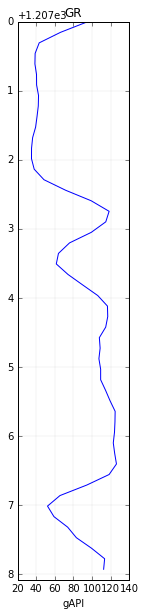

In [12]:
newb = gr.to_basis(start=1207, stop=1215)
newb.plot()

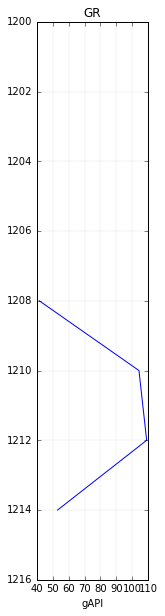

In [15]:
silly = newb.to_basis(start=1200, step=2)
silly.plot()

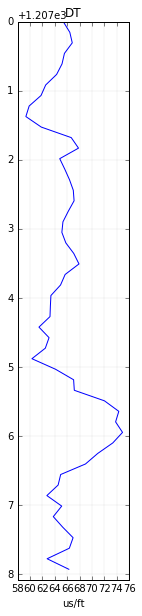

In [17]:
dt = w.data['DT']
dt.to_basis_like(newb.basis).plot()

In [22]:
data = np.array([100, 102, 105, 106, 103, 102, 99, 98, 99, 103])
old_basis = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

new_start = 2
new_adj_stop = 21.001
step = 1


In [21]:
np.arange(2, 5+1e-9, 1)

array([ 2.,  3.,  4.,  5.])

In [23]:
new_basis = np.arange(new_start, new_adj_stop, step)

data = np.interp(new_basis, old_basis, data, left=np.nan, right=np.nan)

In [24]:
data

array([ 100.,  102.,  105.,  106.,  103.,  102.,   99.,   98.,   99.,
        103.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan])

In [142]:
new_basis

array([ 0.1,  0.6,  1.1,  1.6,  2.1,  2.6,  3.1,  3.6,  4.1,  4.6])

## Not implemented yet

PUT WISHED-FOR APIS HERE.